# Feature Selection

Select features using role-agnostic quality + stability filtering, ranked by cross-role variance.

**Pipeline:** not dead → has variance → stable across resamples → rank by `stability × sd`, take top K.

In [1]:
from pathlib import Path

AGGREGATED_DIR = Path("../outputs/aggregated/general/gemma-3-27b-it_layer_40_width_65k_l0_medium") # [n_roles, n_features]
FEATURES_DIR = Path("../outputs/features/general/gemma-3-27b-it_layer_40_width_65k_l0_medium") # [n_responses, n_features] per role
OUTPUT_DIR = Path("../outputs/figures")

STRATEGY = "mean" # or "max"
TOP_K = 2000

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster.hierarchy import linkage, leaves_list
from sklearn.metrics.pairwise import cosine_similarity
from tqdm.auto import tqdm
from umap import UMAP

/home/abu/projects/mech-interp-projects/interpret-personas/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Aggregated Data

In [3]:
data = np.load(AGGREGATED_DIR / STRATEGY / "per_role.npz", allow_pickle=True)
features = data["features"] # [R, D] R = num roles, D = SAE dim
role_names = data["role_names"]
n_roles, sae_dim = features.shape
print(f"{n_roles} roles, {sae_dim:,} SAE features")

17 roles, 65,536 SAE features


# Selection Process

The goal is to:

1. Keep features that vary across roles so that we get persona specific features
2. Keep features whole role pattern is stable across sampled responses so that we minimize prompt variation

The intuition is that features like punctionation, grammar, etc. gets filtered out because they show less variation across roles.

## Step 1: Log Transform + Drop Dead / Low-Variance Features

Log1p prevents activation spikes from skewing the distribution, so one huge role activation does not dominate everything.
Resulting filter keeps features that are active (mean > 0) and variation is above median variation. Each mean and std is calculated within each feature.

In [4]:
R = np.log1p(features)
mu = R.mean(axis=0)
sd = R.std(axis=0)

alive = mu > 0
sd_threshold = np.median(sd[alive])
pass_basic = alive & (sd >= sd_threshold)

print(f"Alive features: {alive.sum():,}")
print(f"SD threshold (median of alive): {sd_threshold:.4f}")
print(f"After basic filter: {pass_basic.sum():,}")

Alive features: 63,114
SD threshold (median of alive): 0.0585
After basic filter: 31,557


## Step 2: Compute Split-Half Stability

For each feature, measure whether its role-profile is reproducible across independent halves of the response data.

A heuristic to obtain features that are stable within the role.

Computing split-half means: 100%|██████████| 17/17 [00:12<00:00,  1.33it/s]


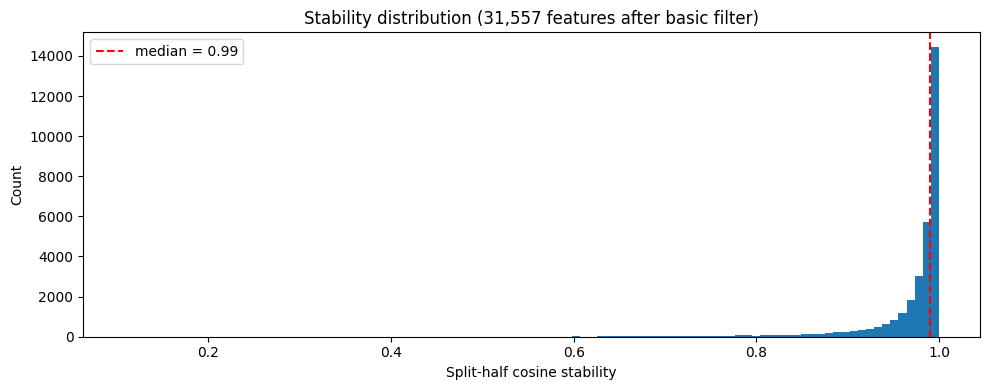

In [5]:
A = np.zeros((n_roles, sae_dim), dtype=np.float32)
B = np.zeros((n_roles, sae_dim), dtype=np.float32)

rng = np.random.RandomState(42)
for r, role in enumerate(tqdm(role_names, desc="Computing split-half means")):
    with np.load(FEATURES_DIR / f"{role}.npz") as npz:
        resp = npz[f"{STRATEGY}_features"]
    idx = rng.permutation(resp.shape[0])
    mid = resp.shape[0] // 2
    A[r] = resp[idx[:mid]].mean(axis=0)
    B[r] = resp[idx[mid:]].mean(axis=0)

num = (A * B).sum(axis=0)
den = np.linalg.norm(A, axis=0) * np.linalg.norm(B, axis=0)
stability = np.divide(num, den, out=np.zeros(sae_dim, dtype=np.float32), where=den > 0)

del A, B

fig, ax = plt.subplots(figsize=(10, 4))
ax.hist(stability[pass_basic], bins=100, edgecolor="none")
ax.set_xlabel("Split-half cosine stability")
ax.set_ylabel("Count")
ax.set_title(f"Stability distribution ({pass_basic.sum():,} features after basic filter)")
median_stab = np.median(stability[pass_basic])
ax.axvline(median_stab, color="red", linestyle="--", label=f"median = {median_stab:.2f}")
ax.legend()
plt.tight_layout()
plt.show()

## Step 3: Select Top K by Stability × Variance

A threshold-free way to select features. stability * sd helps ranking these cases low:
- high variance but unstable
- stable but flat (not informative, common in all roles)
- either weakness

In [6]:
score = stability * sd
score[~pass_basic] = -1

ranking = np.argsort(score)[::-1]
selected = ranking[:TOP_K]

print(f"Selected {len(selected):,} features")
print(f"Score range: [{score[selected[-1]]:.4f}, {score[selected[0]]:.4f}]")
print(f"Stability range: [{stability[selected].min():.3f}, {stability[selected].max():.3f}]")
print(f"SD range: [{sd[selected].min():.4f}, {sd[selected].max():.4f}]")

Selected 2,000 features
Score range: [0.5850, 1.8805]
Stability range: [0.863, 1.000]
SD range: [0.5861, 1.8812]


## Feature Summary

In [7]:
preferred_role_idx = R[:, selected].argmax(axis=0)


def role_profile(feat_idx, R, role_names, top_n=3):
    vals = R[:, feat_idx]
    total = vals.sum()
    if total == 0:
        return "dead"
    order = np.argsort(vals)[::-1][:top_n]
    return " | ".join(f"{role_names[i]}:{vals[i] / total:.0%}" for i in order)


feat_df = pd.DataFrame({
    "feature_idx": selected,
    "preferred_role": role_names[preferred_role_idx],
    "score": score[selected],
    "stability": stability[selected],
    "sd": sd[selected],
    "mu": mu[selected],
    "role_profile": [role_profile(fi, R, role_names) for fi in selected],
})

print("Features per preferred role:")
print(feat_df["preferred_role"].value_counts().to_string())

Features per preferred role:
preferred_role
absurdist        191
historian        181
adolescent       165
economist        151
aberration       144
addict           135
mathematician    129
alien            123
actor            122
biologist        119
activist         112
accountant        97
altruist          84
assistant         82
doctor            82
journalist        52
advocate          31


## Visualizations

### Role-Role Cosine Similarity

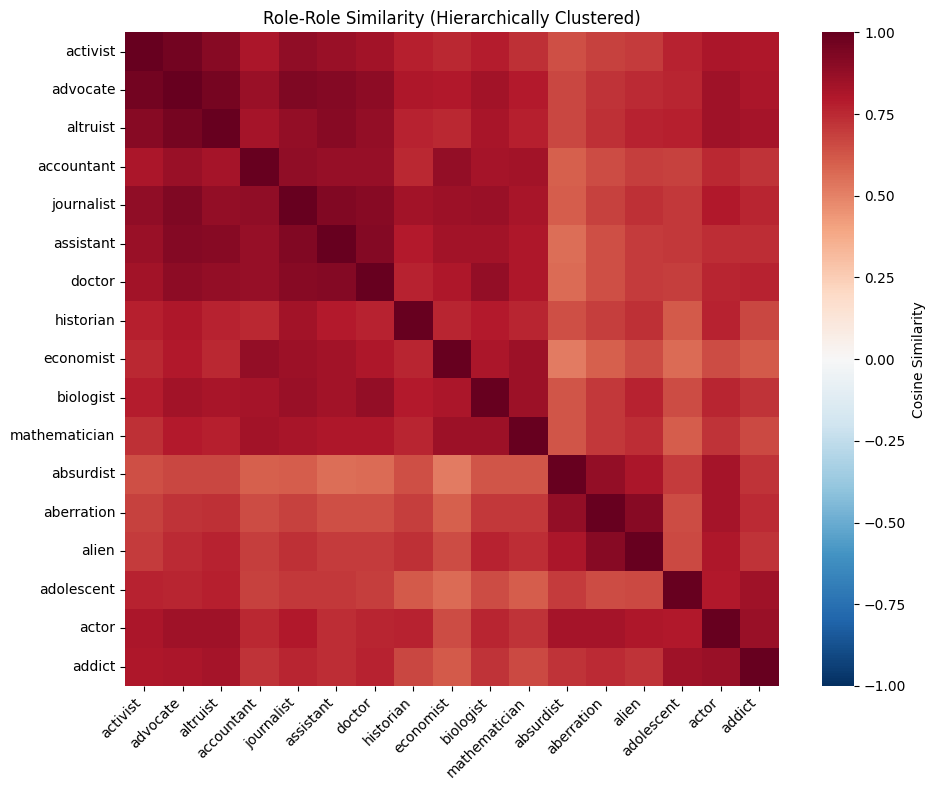

In [8]:
role_vectors = R[:, selected]  # [17, 5000] — each row is a role's feature profile
role_sim = cosine_similarity(role_vectors)

link = linkage(1 - role_sim, method="average")
order = leaves_list(link)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    role_sim[np.ix_(order, order)],
    xticklabels=role_names[order],
    yticklabels=role_names[order],
    cmap="RdBu_r", vmin=-1, vmax=1, center=0, square=True,
    cbar_kws={"label": "Cosine Similarity"}, ax=ax,
)
ax.set_title("Role-Role Similarity (Hierarchically Clustered)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

### UMAP of Features

Each feature is a point in role-space. Distance = "these features prefer similar personas."

Each feature vector is a "role profile": answers which roles activate that feature the most.

/home/abu/projects/mech-interp-projects/interpret-personas/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_936970/514356179.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap("tab20", len(unique_roles))


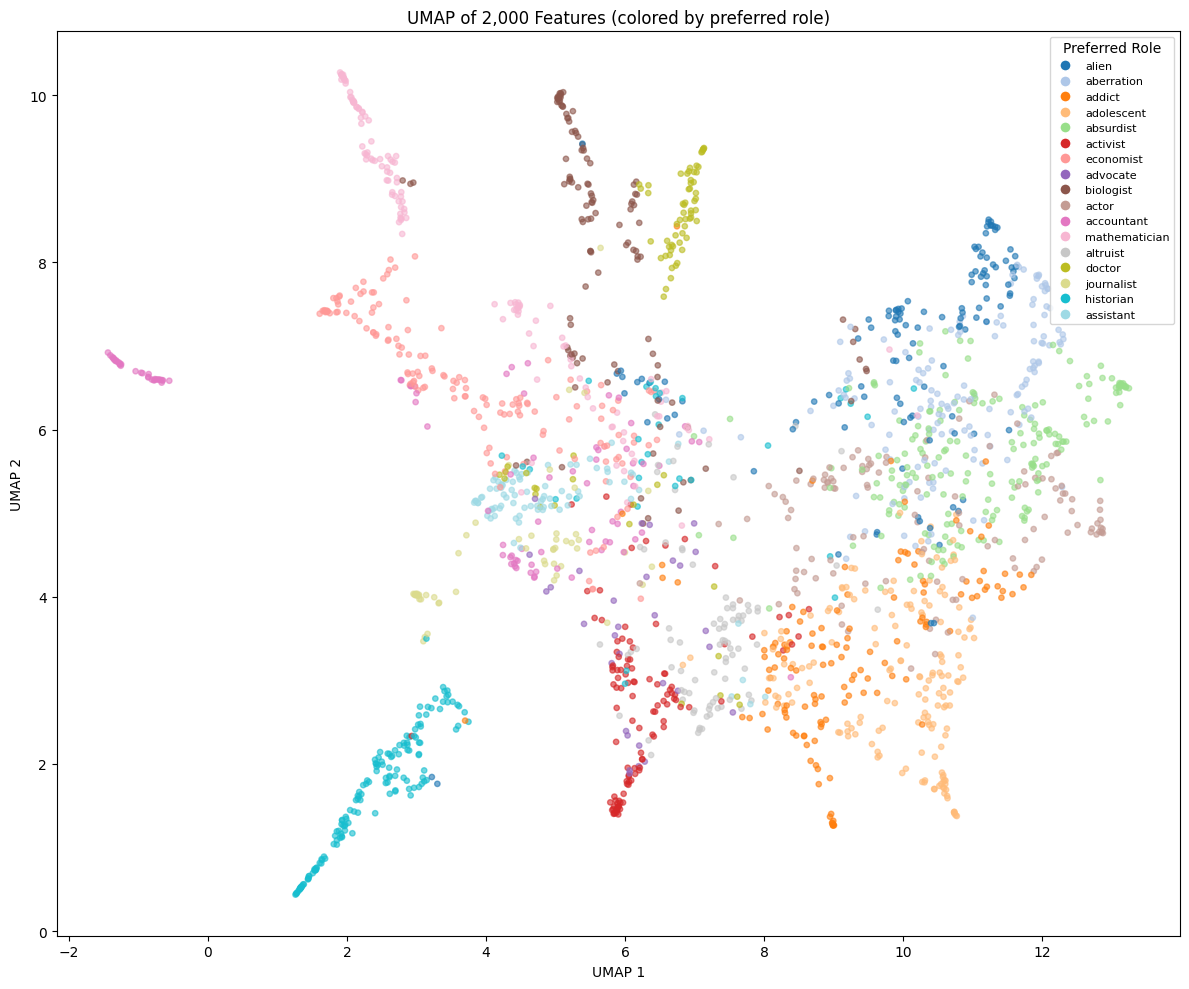

In [9]:
feat_vectors = R[:, selected].T  # [top_k, n_roles] — each row is a feature's role profile

feat_umap = UMAP(
    n_components=2, metric="cosine",
    n_neighbors=15, min_dist=0.1, random_state=24,
).fit_transform(feat_vectors)

unique_roles = feat_df["preferred_role"].unique()
cmap = plt.cm.get_cmap("tab20", len(unique_roles))
role_to_idx = {r: i for i, r in enumerate(unique_roles)}
colors = [role_to_idx[r] for r in feat_df["preferred_role"]]

fig, ax = plt.subplots(figsize=(12, 10))
ax.scatter(
    feat_umap[:, 0], feat_umap[:, 1],
    c=colors, cmap=cmap, vmin=0, vmax=len(unique_roles) - 1,
    s=15, alpha=0.6,
)
handles = [
    plt.Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(i), markersize=8, label=r)
    for i, r in enumerate(unique_roles)
]
ax.legend(handles=handles, title="Preferred Role", loc="upper right", fontsize=8)
ax.set_xlabel("UMAP 1")
ax.set_ylabel("UMAP 2")
ax.set_title(f"UMAP of {TOP_K:,} Features (colored by preferred role)")
plt.tight_layout()
plt.show()

### PCA of Roles

Each role is a point in feature-space. PCA finds the linear axes along which roles differ most. Each PC axis is a weighted combination of SAE features (`pca.components_`), so inspecting the top-weighted features on an axis can reveal what it captures (e.g. "assistant-like vs. absurd"). A role's score on PC1 is how far it sits along the dominant axis of variation.

In [11]:
import numpy as np
from sklearn.decomposition import PCA

X = R[:, selected]
X = X - X.mean(axis=0, keepdims=True)

pca = PCA(n_components=5, random_state=0)
role_scores = pca.fit_transform(X)        # shape [n_roles, n_components]

role_pc1 = role_scores[:, 0]              # one number per role
order = np.argsort(role_pc1)
for i in order:
    print(f"{role_pc1[i]:+.3f}  {role_names[i]}")

-26.018  economist
-19.136  doctor
-18.924  assistant
-18.006  accountant
-16.736  journalist
-12.147  mathematician
-12.106  biologist
-9.761  advocate
-7.849  activist
-6.255  historian
-4.870  altruist
+15.148  adolescent
+15.623  addict
+21.174  actor
+24.868  alien
+34.137  aberration
+40.859  absurdist
